**Important Notes**

The most likely reason for weird A/B test results are:
- We didn't get enough data
- Some bias have been introduced in the experiment so that test/control people are not really random

## To confirm the test is negative

In [80]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind
import numpy as np

In [41]:
test = pd.read_csv('../DS_Challenges/Translation_Test/test_table.csv')
user = pd.read_csv('../DS_Challenges/Translation_Test/user_table.csv')
test.head()

,user_id,date,source,device,browser_language,ads_channel,browser,conversion,test
0,315281,2015-12-03,Direct,Web,ES,NaN,IE,1,0
1,497851,2015-12-04,Ads,Web,ES,Google,IE,0,1
2,848402,2015-12-04,Ads,Web,ES,Facebook,Chrome,0,0
3,290051,2015-12-03,Ads,Mobile,Other,Facebook,Android_App,0,1
4,548435,2015-11-30,Ads,Web,ES,Google,FireFox,0,1


In [42]:
user.head()

,user_id,sex,age,country
0,765821,M,20,Mexico
1,343561,F,27,Nicaragua
2,118744,M,23,Colombia
3,987753,F,27,Venezuela
4,554597,F,20,Spain


In [43]:
combined = test.merge(user, on = 'user_id', how = 'outer')
combined.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 453321 entries, 0 to 453320
Data columns (total 12 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   user_id           453321 non-null  int64  
 1   date              453321 non-null  object 
 2   source            453321 non-null  object 
 3   device            453321 non-null  object 
 4   browser_language  453321 non-null  object 
 5   ads_channel       181877 non-null  object 
 6   browser           453321 non-null  object 
 7   conversion        453321 non-null  int64  
 8   test              453321 non-null  int64  
 9   sex               452867 non-null  object 
 10  age               452867 non-null  float64
 11  country           452867 non-null  object 
dtypes: float64(1), int64(3), object(8)
memory usage: 45.0+ MB


In [45]:
combined.sample(5)

,user_id,date,source,device,browser_language,ads_channel,browser,conversion,test,sex,age,country
424936,889430,2015-12-04,SEO,Web,ES,NaN,Safari,0,0,M,26.0,Venezuela
120730,420126,2015-12-02,SEO,Web,ES,NaN,IE,0,0,M,29.0,Peru
77284,260990,2015-12-02,Ads,Mobile,EN,Google,Iphone_App,0,0,F,35.0,Argentina
86544,950199,2015-12-01,SEO,Mobile,ES,NaN,Android_App,0,0,F,18.0,Costa Rica
171290,729207,2015-12-03,SEO,Web,ES,NaN,Chrome,0,0,M,20.0,Mexico


Let's first confirm that Spain converted much better than the rest of LatAm countries

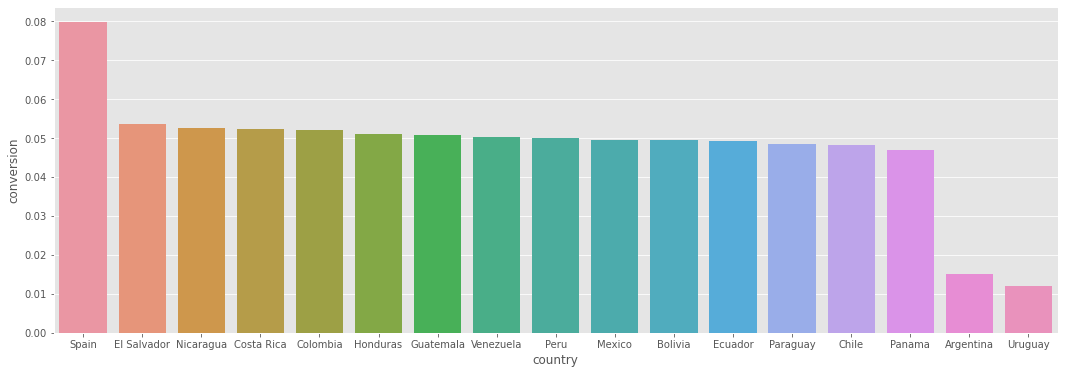

In [63]:
# groupby
groups = combined.loc[combined['test']==0].groupby('country').\
        agg({'conversion':'mean'}).\
        sort_values(by = 'conversion', ascending = False).\
        reset_index()

# Visualization
fig, ax = plt.subplots(figsize=(18, 6))
sns.barplot(x='country', y='conversion', data=groups, ax=ax)
plt.show()

In [76]:
control = combined.loc[combined['test']==0]
test = combined.loc[combined['test']==1]
control.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 237338 entries, 0 to 453318
Data columns (total 12 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   user_id           237338 non-null  int64  
 1   date              237338 non-null  object 
 2   source            237338 non-null  object 
 3   device            237338 non-null  object 
 4   browser_language  237338 non-null  object 
 5   ads_channel       95348 non-null   object 
 6   browser           237338 non-null  object 
 7   conversion        237338 non-null  int64  
 8   test              237338 non-null  int64  
 9   sex               237093 non-null  object 
 10  age               237093 non-null  float64
 11  country           237093 non-null  object 
dtypes: float64(1), int64(3), object(8)
memory usage: 23.5+ MB


In [77]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 215983 entries, 1 to 453320
Data columns (total 12 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   user_id           215983 non-null  int64  
 1   date              215983 non-null  object 
 2   source            215983 non-null  object 
 3   device            215983 non-null  object 
 4   browser_language  215983 non-null  object 
 5   ads_channel       86529 non-null   object 
 6   browser           215983 non-null  object 
 7   conversion        215983 non-null  int64  
 8   test              215983 non-null  int64  
 9   sex               215774 non-null  object 
 10  age               215774 non-null  float64
 11  country           215774 non-null  object 
dtypes: float64(1), int64(3), object(8)
memory usage: 21.4+ MB


In [78]:
# A/B test
test_data = combined[combined['country'] != 'Spain']
test_val = test_data[test_data['test'] == 1]['conversion'].values
cont_val = test_data[test_data['test'] == 0]['conversion'].values

print(test_val.mean(), '\t', cont_val.mean())

0.043424713982118966 	 0.04833042316066309


In [75]:
print(ttest_ind(test_val, cont_val, equal_var=False))

Ttest_indResult(statistic=-7.3939374121344805, pvalue=1.4282994754055316e-13)


- As we can see above that the conversion rate of control group is 4.8% while that of test group is only 4.3%.
- And p-value is lower than 0.05
- So at initial glance, we find that the test is negative
- But we cannot drive to the conclusion that the test is negative without digging more, e.g. we need to control for other variables.

In [14]:
test.browser_language.value_counts()

ES       179598
EN        30106
Other      6070
Name: browser_language, dtype: int64

In [15]:
control.browser_language.value_counts()

ES       197562
EN        32973
Other      6558
Name: browser_language, dtype: int64

In [16]:
test.country.value_counts()

Mexico         64275
Argentina      37377
Colombia       26972
Peru           16797
Venezuela      15905
Chile           9884
Ecuador         7859
Guatemala       7503
Bolivia         5574
Honduras        4207
El Salvador     4067
Uruguay         3719
Paraguay        3697
Nicaragua       3304
Costa Rica      2649
Panama          1985
Name: country, dtype: int64

## Why the test is negative?

In [17]:
test.head()

,user_id,date,source,device,browser_language,ads_channel,browser,conversion,test,sex,age,country
1,497851,2015-12-04,Ads,Web,ES,Google,IE,0,1,M,21,Mexico
3,290051,2015-12-03,Ads,Mobile,Other,Facebook,Android_App,0,1,F,22,Mexico
4,548435,2015-11-30,Ads,Web,ES,Google,FireFox,0,1,M,19,Mexico
5,540675,2015-12-03,Direct,Mobile,ES,NaN,Android_App,0,1,F,22,Venezuela
8,261625,2015-12-04,Direct,Mobile,ES,NaN,Android_App,0,1,M,31,Bolivia


#### Country

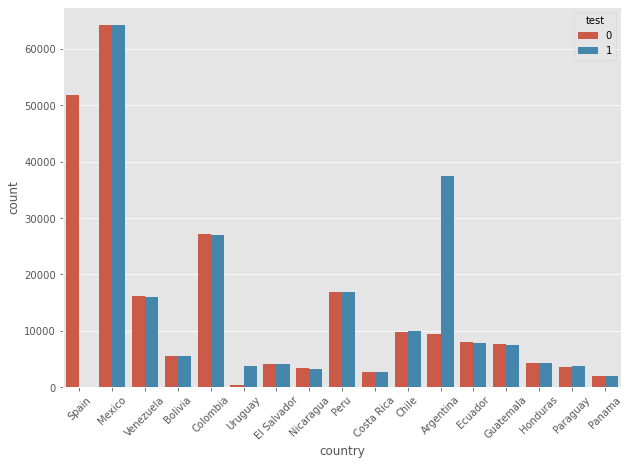

In [21]:
plt.style.use('ggplot')
plt.figure(figsize = (10,7))
sns.countplot(data = combined, x = 'country', hue = 'test')
plt.xticks(rotation=45)
plt.show()

It seems that the population of Uruguay and Argentina is biased. Let's see whether this affects

In [22]:
test[test['country']=='Argentina'].conversion.value_counts(normalize = True)

0    0.986275
1    0.013725
Name: conversion, dtype: float64

In [23]:
control[control['country']=='Argentina'].conversion.value_counts(normalize = True)

0    0.984929
1    0.015071
Name: conversion, dtype: float64

In [24]:
test[test['country']=='Uruguay'].conversion.value_counts(normalize = True)

0    0.987093
1    0.012907
Name: conversion, dtype: float64

In [25]:
control[control['country']=='Uruguay'].conversion.value_counts(normalize = True)

0    0.987952
1    0.012048
Name: conversion, dtype: float64

We can see that Argentina affects a bit, since it turns down the conversion rate of test group.

#### date

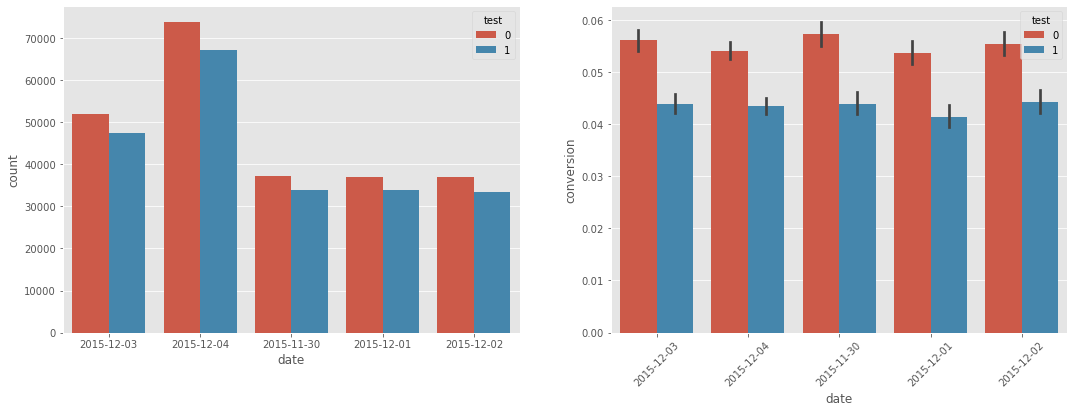

In [92]:
fig, ax= plt.subplots(1,2,figsize=(18,6))
sns.countplot(data = combined, x = 'date', hue = 'test', ax=ax[0])
sns.barplot(data = combined, x = 'date', y = 'conversion', hue = 'test', ax=ax[1])
plt.xticks(rotation=45)
plt.show()

#### others

In [37]:
col = ~combined.columns.isin(['user_id','date'])
col = combined.columns[col]


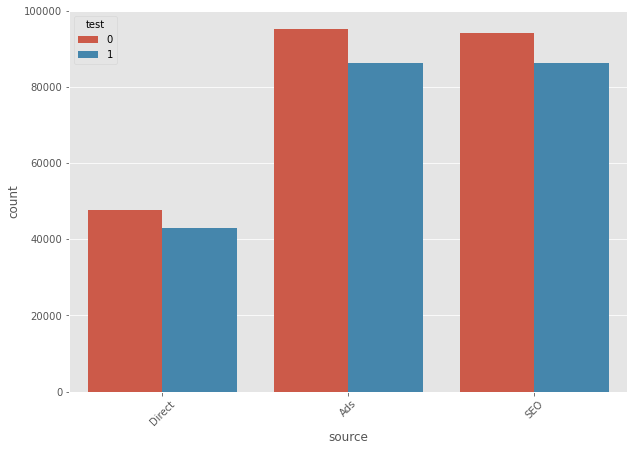

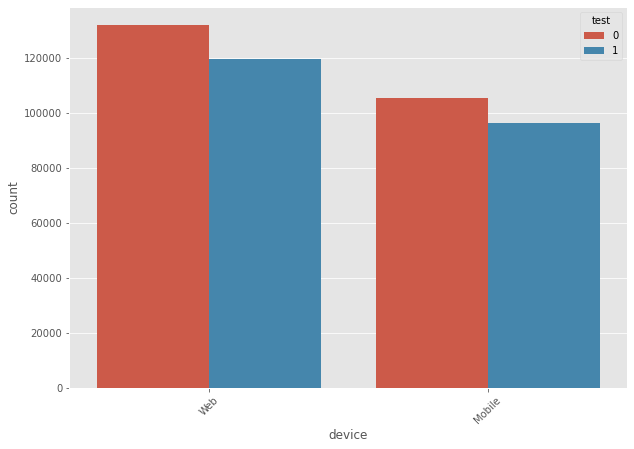

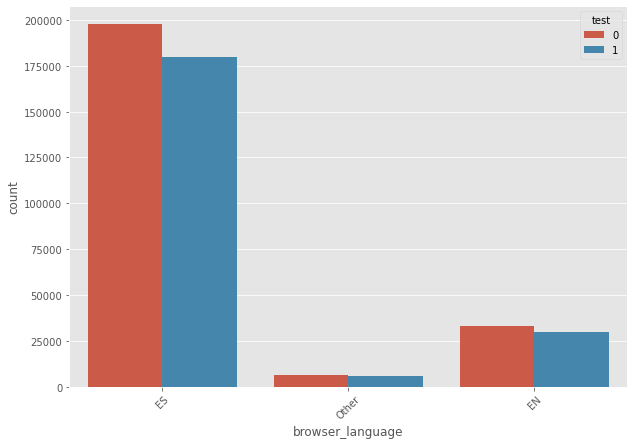

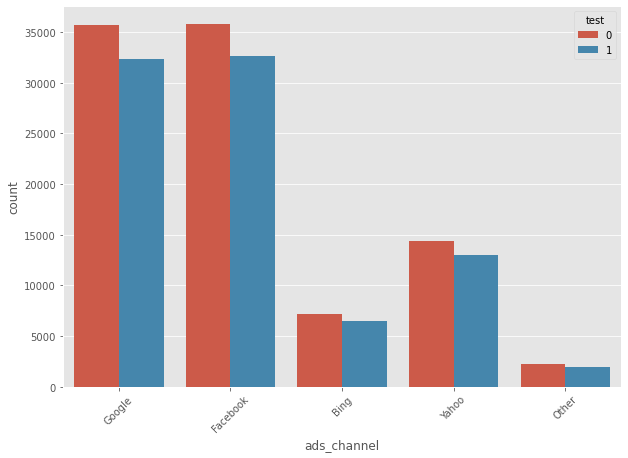

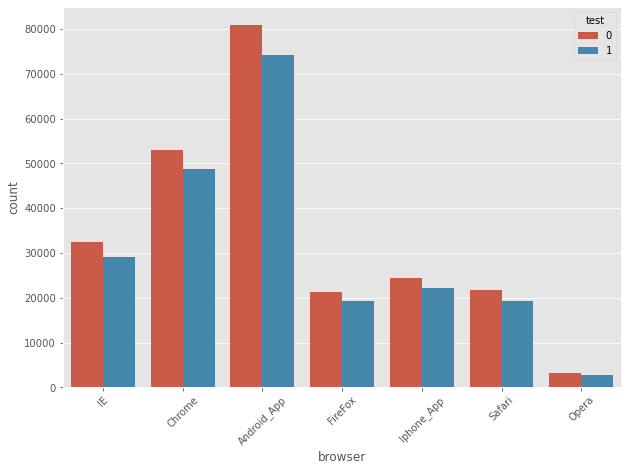

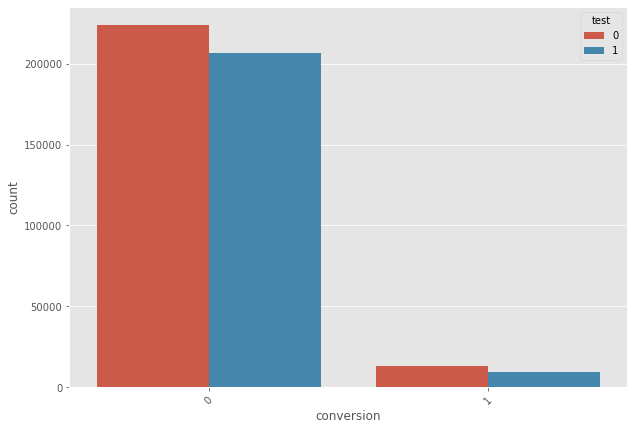

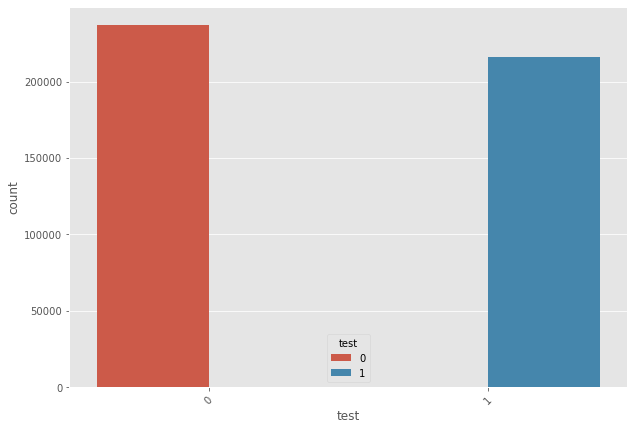

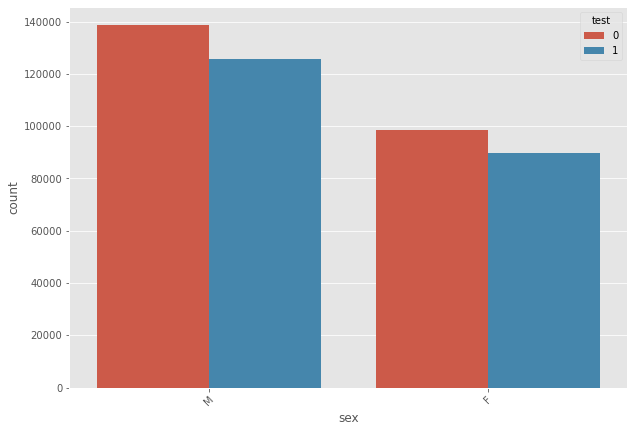

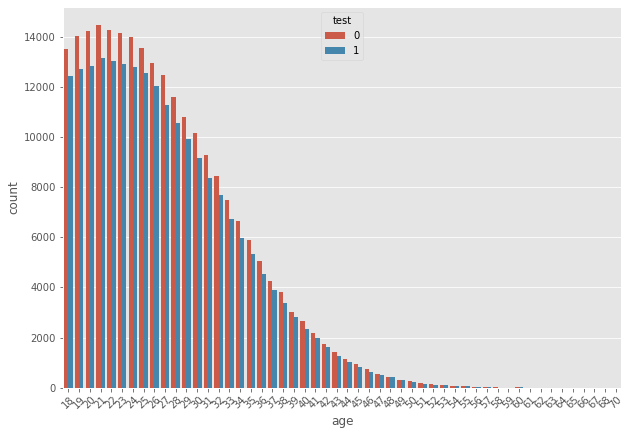

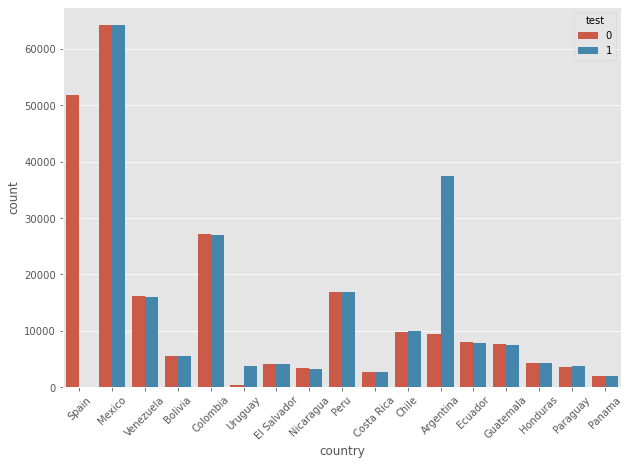

In [38]:
plt.style.use('ggplot')
for i in col:
    plt.figure(figsize = (10,7))
    sns.countplot(data = combined, x = i, hue = 'test')
    plt.xticks(rotation=45)
    plt.show()

We can see from above figures that other variables do not differ much between control and test

In [84]:
countries = [name for name in test_data['country'].unique() if name is not np.nan]

print('{0:15s} {1:>15s} {2:>15s} {3:>10s}'.format('Country', 'Test Rate', 'Control Rate', 'P-Value'))
print('-' * 65)
for country in countries:
    test_val = test[test['country'] == country]['conversion'].values
    cont_val = control[control['country'] == country]['conversion'].values
    
    test_mean = test_val.mean()
    cont_mean = cont_val.mean()
    p_val = ttest_ind(test_val, cont_val, equal_var=False).pvalue
    
    print('{0:15s} {1:15.5f} {2:15.5f} {3:10f}'.format(country, test_mean, cont_mean, p_val))

Country               Test Rate    Control Rate    P-Value
-----------------------------------------------------------------
Mexico                  0.05119         0.04949   0.165544
Venezuela               0.04898         0.05034   0.573702
Bolivia                 0.04790         0.04937   0.718885
Colombia                0.05057         0.05209   0.423719
Uruguay                 0.01291         0.01205   0.879764
El Salvador             0.04795         0.05355   0.248127
Nicaragua               0.05418         0.05265   0.780400
Peru                    0.05060         0.04991   0.771953
Costa Rica              0.05474         0.05226   0.687876
Chile                   0.05130         0.04811   0.302848
Argentina               0.01373         0.01507   0.335147
Ecuador                 0.04899         0.04915   0.961512
Guatemala               0.04865         0.05064   0.572107
Honduras                0.04754         0.05091   0.471463
Paraguay                0.04923         0.04849  

As we could see above that after controlling for country the p-value of different countries are above 0.05, which means the differences are not significant. So we could drive to the conclusion that the test IS NOT NEGATIVE!